# Importing Libraries 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
mnist_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

mnist_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

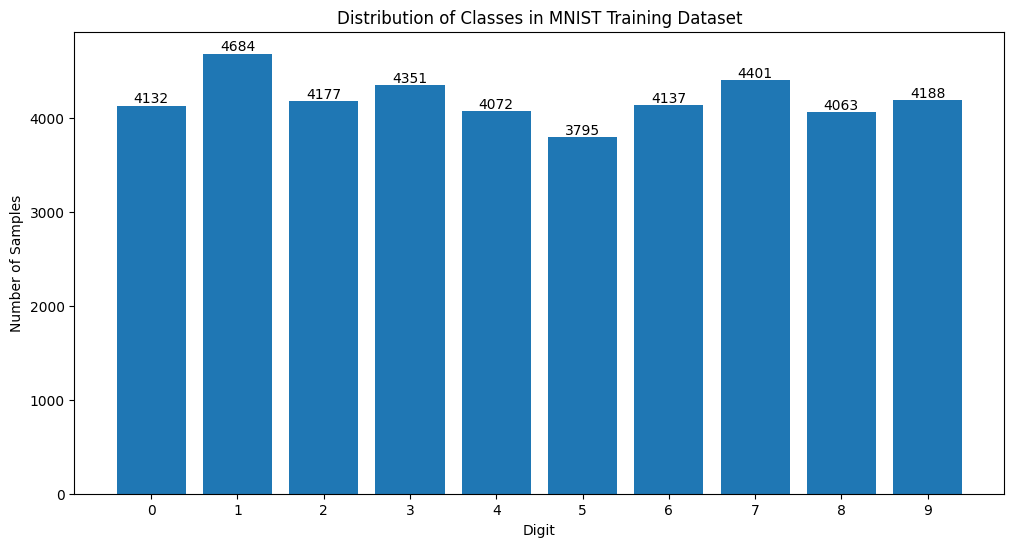

In [3]:
# Count the occurrences of each class
class_counts = mnist_train['label'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values, align='center')
plt.title('Distribution of Classes in MNIST Training Dataset')
plt.xlabel('Digit')
plt.ylabel('Number of Samples')
plt.xticks(range(10))

# Add value labels on top of each bar
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()

In [4]:
X = mnist_train.drop(columns=['label'])
y = mnist_train['label']

In [5]:
X.shape

(42000, 784)

In [6]:
# Normalize pixel values to be between 0 and 1
X = X / 255.0
mnist_test = mnist_test / 255.0 

In [7]:
# Splitting the dataset into training and validation sets 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
#print(X_train.shape)
#print(y_train.shape)

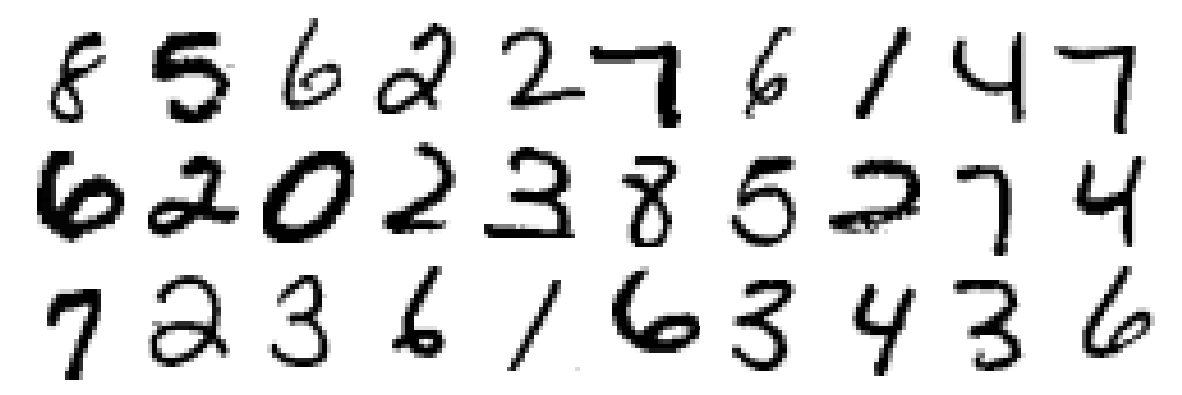

In [9]:
X_reshaped = X_train.to_numpy().reshape(-1,28,28,1) 

plt.figure(figsize=(15,5))
for i in range(30): 
    plt.subplot(3,10, i+1) 
    plt.imshow(X_reshaped[i, :, :, 0], cmap=plt.cm.binary) 
    plt.axis('off') 
plt.subplots_adjust(wspace=-0.1, hspace=-0.1) 
plt.show()    

# Dense Neural Network

In [10]:
input_shape = [X_train.shape[1]]

# Define the model
model = Sequential([
    Dense(units=128, activation='relu', input_shape= input_shape),
    Dense(units=64, activation='relu'),
    Dense(units=10, activation='softmax')
])

In [11]:
# Compile the model
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [12]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=30,
)

Epoch 1/30


I0000 00:00:1727656934.361396      99 service.cc:145] XLA service 0x7c1cb0006ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727656934.361440      99 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727656934.361446      99 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 106/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5978 - loss: 1.3682

I0000 00:00:1727656935.763391      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1182/1182 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8540 - loss: 0.5064 - val_accuracy: 0.9514 - val_loss: 0.1584
Epoch 2/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9632 - loss: 0.1236 - val_accuracy: 0.9607 - val_loss: 0.1257
Epoch 3/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9755 - loss: 0.0794 - val_accuracy: 0.9652 - val_loss: 0.1160
Epoch 4/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9820 - loss: 0.0575 - val_accuracy: 0.9719 - val_loss: 0.0899
Epoch 5/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9881 - loss: 0.0411 - val_accuracy: 0.9724 - val_loss: 0.0972
Epoch 6/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9888 - loss: 0.0346 - val_accuracy: 0.9686 - val_loss: 0.1096
Epoch 7/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9906 - loss: 0.0303 - val_accuracy: 0.9738 - val_loss: 0.0963
Epoch 8/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9915 - loss: 0.0250 - val_accurac

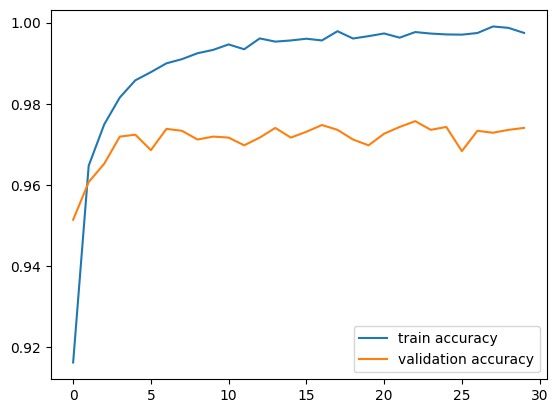

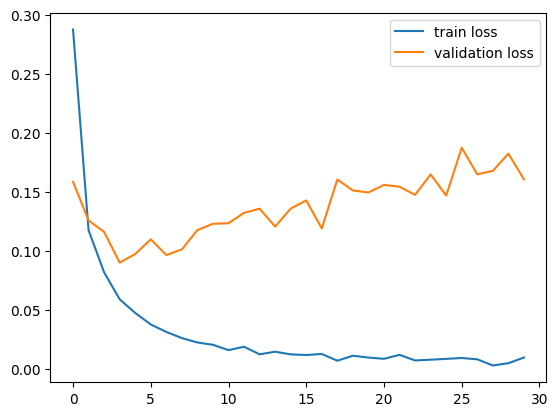

In [13]:
history_df = pd.DataFrame(history.history)

# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

The model is performing significantly better on the training data compared to the validation data, indicating overfitting. Overfitting occurs when the model captures too much noise from the training set, preventing the loss from being as low as possible. To address this, we will increase the model's capacity and implement early stopping, which will stop training once the validation loss stops decreasing.

In [14]:
model = Sequential([
    BatchNormalization(input_shape=input_shape),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], 
    verbose=0,  # turn off training log
)

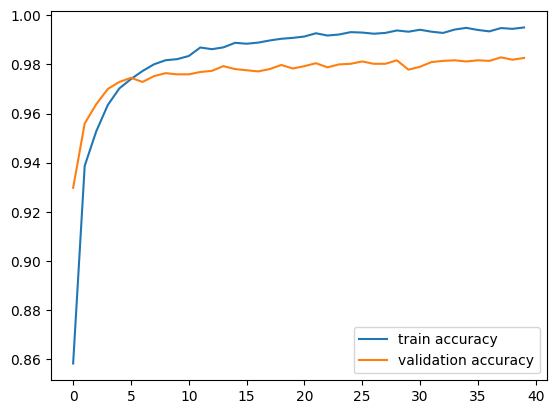

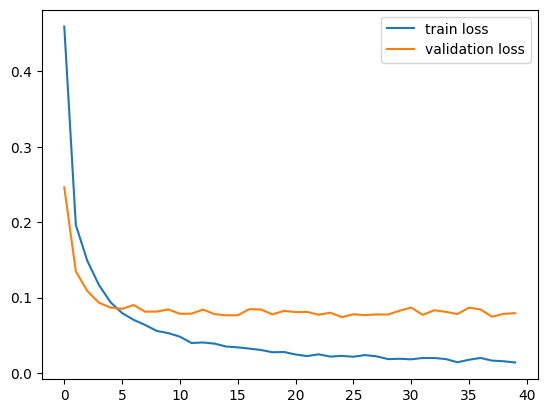

In [17]:
history_df = pd.DataFrame(history.history)

# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

The results are promising, but we will take it a step further by implementing a CNN, which is better suited for our dataset.

# CNN

In [18]:
# Function to convert and reshape data to 2D
def convert_and_reshape(data):
    if isinstance(data, pd.DataFrame):
        return data.to_numpy().reshape(-1, 28, 28, 1)
    elif isinstance(data, np.ndarray):
        return data.reshape(-1, 28, 28, 1)
    else:
        raise TypeError("Input must be a pandas DataFrame or a numpy array")

# Converting and reshaping X_train
X_train = convert_and_reshape(X_train)

# Converting and reshaping X_valid
X_valid = convert_and_reshape(X_valid)

# Converting and reshaping X_test
X_test = convert_and_reshape(mnist_test)

In [19]:
# Define the model
model = tf.keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    # Classifier Head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
#model.summary()

In [20]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=30,
) 

Epoch 1/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7568 - loss: 0.7395 - val_accuracy: 0.9681 - val_loss: 0.1045
Epoch 2/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9589 - loss: 0.1344 - val_accuracy: 0.9752 - val_loss: 0.0796
Epoch 3/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9699 - loss: 0.1007 - val_accuracy: 0.9812 - val_loss: 0.0587
Epoch 4/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9738 - loss: 0.0846 - val_accuracy: 0.9833 - val_loss: 0.0591
Epoch 5/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9804 - loss: 0.0630 - val_accuracy: 0.9840 - val_loss: 0.0484
Epoch 6/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9805 - loss: 0.0610 - val_accuracy: 0.9867 - val_loss: 0.0439
Epoch 7/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9806 - loss: 0.0591 - val_accuracy: 0.9860 - val_loss: 0.0416
Epoch 8/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9840 - loss: 0.0510 -

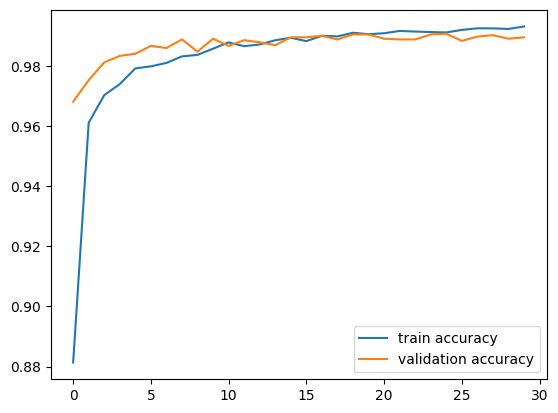

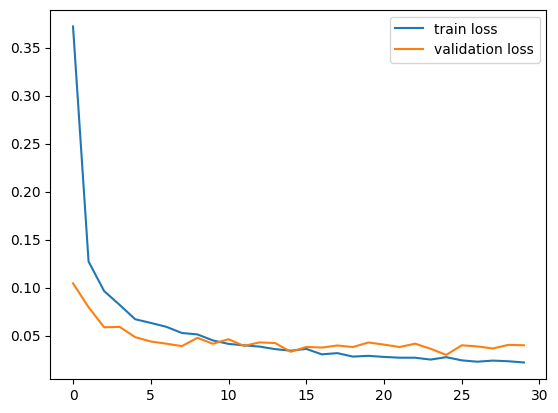

In [21]:
history_df = pd.DataFrame(history.history)

# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# Data Augmentation

Data augmentation is a technique used to artificially increase the size and diversity of a training dataset by applying various transformations to existing images.

Common augmentation techniques include:

1. Rotation: Slightly rotating the digits (usually within a small range, e.g., ±10 degrees).
2. Zooming: Slightly increasing or decreasing the size of the digit.
3. Width and height shifts: Moving the digit up, down, left, or right.

These transformations help the model learn to recognize digits in various orientations and styles, potentially improving its generalization capabilities. 

In [22]:
datagen = ImageDataGenerator(
    rotation_range=5,  # Rotate the image by up to 5 degrees
    width_shift_range=0.1,  # Shift the image horizontally by up to 10% of its width
    height_shift_range=0.1,  # Shift the image vertically by up to 10% of its height
    zoom_range=0.1,  # Zoom in or out by up to 10%
    fill_mode='nearest'  # Fill in newly created pixels using the nearest neighbor
)

datagen.fit(X_train) 

In [23]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding='same', input_shape=[28, 28, 1]),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.3),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.3),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(units=64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(units=10, activation="softmax"),
])

#print(model.summary())

In [24]:
# compile the model
model.compile(optimizer= Adam(learning_rate=0.001),
              loss= 'sparse_categorical_crossentropy',
              metrics= ['accuracy'])

In [25]:
# Early Stopping
#early_stopping = tf.keras.callbacks.EarlyStopping( 
#    monitor='val_loss',
#    patience=10,
#    restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_valid, y_valid)
)  
    #callbacks=[early_stopping])

Epoch 1/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.5607 - loss: 1.3387 - val_accuracy: 0.9781 - val_loss: 0.0708
Epoch 2/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9207 - loss: 0.2666 - val_accuracy: 0.9817 - val_loss: 0.0603
Epoch 3/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9423 - loss: 0.1880 - val_accuracy: 0.9862 - val_loss: 0.0459
Epoch 4/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9524 - loss: 0.1664 - val_accuracy: 0.9888 - val_loss: 0.0377
Epoch 5/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9608 - loss: 0.1318 - val_accuracy: 0.9893 - val_loss: 0.0311
Epoch 6/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9614 - loss: 0.1307 - val_accuracy: 0.9845 - val_loss: 0.0446
Epoch 7/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9650 - loss: 0.1199 - val_accuracy: 0.9881 - val_loss: 0.0370
Epoch 8/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9685 -

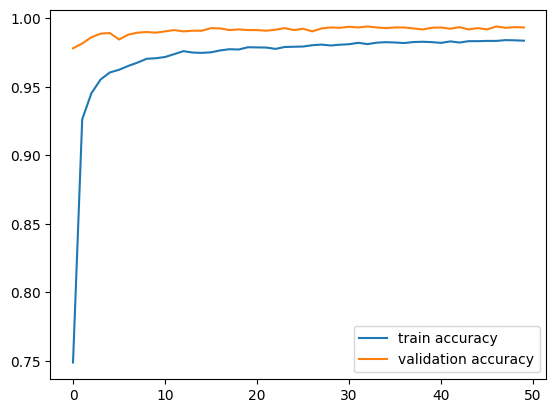

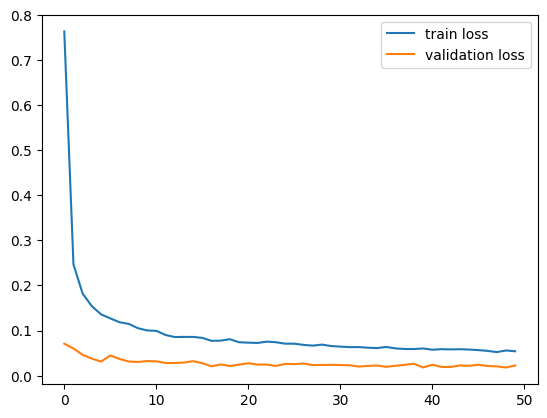

In [26]:
history_df = pd.DataFrame(history.history)

# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# Confusion Matrix

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


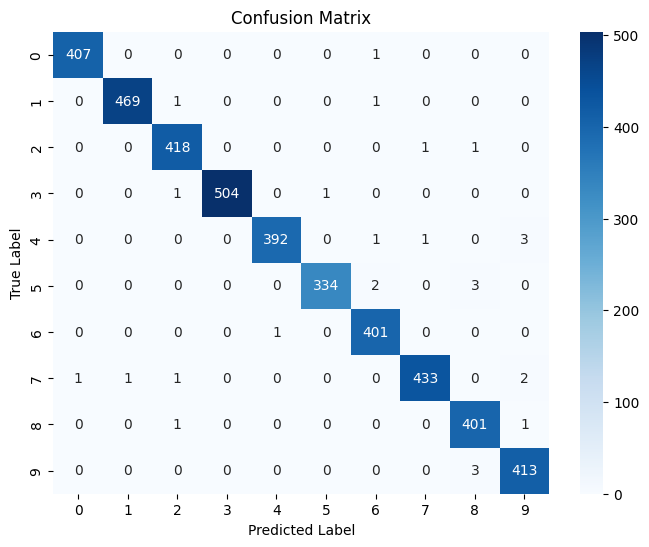

In [27]:
# 1. Make predictions on the validation set
y_pred_probs = model.predict(X_valid)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# 2. Generate the confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred)

# 3. Define class names (digits 0 to 9)
class_names = [i for i in range(10)]

# 4. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Submission

In [28]:
predictions = model.predict(X_test, batch_size=128) 

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [29]:
predicted_classes = np.argmax(predictions, axis=1)

In [30]:
submission_df = pd.DataFrame({
    'ImageId': range(1, len(predicted_classes) + 1),
    'Label': predicted_classes
})
submission_df.to_csv('submission.csv', index=False)

In [31]:
#submission_df

Thank you for exploring this notebook! If you enjoyed it and found value in the content, please consider giving it an upvote ⬆️. Your support means a lot to me and encourages me to create more helpful notebooks